## Current and historical weather

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layers
- Querying the data layers
    - Point query
    - Raster query
- References

### Overview

Current and historical weather data set, also referred to as TWC GCOD Data, provides high-resolution, hourly global weather data at a 4km grid resolution , covering both landmasses and coastal waterways. The dataset spans from **July 2015 to present**, offering detailed meteorological information that is crucial for a range of applications including environmental monitoring, weather forecasting, and operational planning. The data is updated hourly (every 20 minutes past every hour).

#### Key Features:
- **Grid Resolution**: 4km, covering both **landmass** and **coastal waterways**, ensuring high accuracy and granularity for localized weather analysis.
- **Temporal Resolution**: **Hourly data**, offering up-to-date insights into the evolving weather conditions.
- **Historical Coverage**: Data is available from **July 2015** to the present, allowing for comprehensive long-term weather trend analysis.

#### Special Case Data:
- **Driving Difficulty Index**: Available only from **December 15, 2015, 17Z** onward. This index helps assess weather-related challenges for transportation and road conditions.
- **Pressure Mean Sea Level (MSL)**: Available only from **July 17, 2017, 15Z** onward. Provides high-accuracy atmospheric pressure data at sea level.
- **Wind Direction**: Available only from **July 17, 2017, 15Z** onward. Helps in tracking wind patterns and their influence on climate and weather systems.

This gridded dataset is ideal for industries and applications that require precise, high-frequency weather data, including climate research, logistics, agriculture, and environmental monitoring. The flexibility of on-demand access ensures that users can retrieve the data they need when they need it, with the ability to perform custom analysis or integrate with other systems.



### Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the config below.

```config.read('../../../../auth/secrets.ini')```

In [4]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import datetime
import configparser
import pandas as pd
import ibmpairs.client as client  # represents an authenticated HTTP client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import matplotlib.pyplot as plt
import os
import json
import numpy as np


def now():
    return datetime.datetime.utcnow().isoformat()


print(f"Current time: {now()}")
print("Imports initialized.")

Current time: 2025-01-22T17:20:53.305773
Imports initialized.


### Get authentication token

In [7]:
config = configparser.RawConfigParser()
config.read("../../../../auth/secrets.ini")
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY = config.get("EI", "api.api_key")
EI_TENANT_ID = config.get("EI", "api.tenant_id")
EI_ORG_ID = config.get("EI", "api.org_id")

EI_client_v3 = client.get_client(
    api_key=EI_API_KEY,
    tenant_id=EI_TENANT_ID,
    org_id=EI_ORG_ID,
    legacy=False,
    version=3
)

2025-01-22 22:51:06 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-22 22:51:06 - paw - INFO - Legacy Environment is False
2025-01-22 22:51:06 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-22 22:51:08 - paw - INFO - Authentication success.
2025-01-22 22:51:08 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


### Data layers

To get started, we’ll first explore the **catalog sub-module** of the `ibmpairs` library. This will allow us to retrieve the **dataset_id** and the associated **datalayer(s)** that comprise the dataset we’re interested in querying. By identifying the correct dataset and its structure, we can ensure that we are working with the right data for our analysis. 

Let’s walk through this process step by step.

In [5]:
# search for datasets by name
filter_catalogue_search_df = catalog.search("Current and historical weather")
filter_catalogue_search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,157,49247,Wind gust,Sudden and temporary variations of the average...,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
1,157,49248,Pressure change past 3 h,The change in the barometric pressure reading ...,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
2,157,49249,Precip past 1 h,Rolling one-hour liquid precipitation amount. ...,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
3,157,49250,Precip past 24 h,Rolling twenty-four hour liquid precipitation ...,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
4,157,49251,Precip past 6 h,Rolling six-hour liquid precipitation amount. ...,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
5,157,49252,Relative humidity surface,"The relative humidity of the air, which is def...",14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
6,157,49253,Sensible weather,The layer gives a numerical value that categor...,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
7,157,49254,Snow past 1 h,Rolling one-hour snowfall amount. Unit: m,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
8,157,49255,Snow past 24 h,Rolling twenty-four hour snowfall amount. Unit: m,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...
9,157,49256,Snow past 6 h,Rolling six-hour snowfall amount. Unit: m,14,Raster,,Current and historical weather,4km landmass and coastal waterways grid and ho...


As shown above, the Data Set with ID 157 contains multiple Data Layers with IDs - 49247, 49248, 49249, 49250, 49251, 49252, 49253, 49254, 49255, 49256, 49257, 49304, 49305, 49308, 49309, 49310, 49311, 49312, 49313, 49314. To gain a better understanding of the Data Set, including its geospatial and temporal coverage, as well as other relevant metadata, we can perform additional queries in the catalog submodule, as outlined in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

### Querying the data layers

#### Point query
Next, let us make a point query pointing to a location on Vancouver Island, British Columbia, Canada, specifically near the west coast of the island to observe key meteorological parameters to highlight variations in weather conditions

In [59]:
# Submit the query
query_result = query.submit(
    {
        "layers": [
            {
                "type": "raster", 
                "id": "49247"
            },
            {
                "type": "raster", 
                "id": "49248"
            },
            {
                "type": "raster", 
                "id": "49249"
            },
            {
                "type": "raster", 
                "id": "49250"
            },
            {
                "type": "raster", 
                "id": "49251"
            },
            {
                "type": "raster", 
                "id": "49252"
            },
            {
                "type": "raster", 
                "id": "49253"
            },
            {
                "type": "raster", 
                "id": "49254"
            },
            {
                "type": "raster", 
                "id": "49255"
            },
            {
                "type": "raster", 
                "id": "49256"
            },
            {
                "type": "raster", 
                "id": "49257"
            },
            {
                "type": "raster", 
                "id": "49304"
            },
            {
                "type": "raster", 
                "id": "49305"
            },
            {
                "type": "raster", 
                "id": "49308"
            },
            {
                "type": "raster", 
                "id": "49309"
            },
            {
                "type": "raster", 
                "id": "49310"
            },
            {
                "type": "raster", 
                "id": "49311"
            },
            {
                "type": "raster", 
                "id": "49312"
            },
            {
                "type": "raster", 
                "id": "49313"
            },
            {
                "type": "raster", 
                "id": "49314"
            }
        ],
        "spatial": {
            "type": "point",
            "coordinates": [
                "49.329",
                "-125.627"
            ]  # point in west coast of Vancouver island
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2024-12-25T00:20:00Z", 
                    "end": "2024-12-25T01:19:00Z"
                }
            ]
        }
    },
    client=EI_client_v3
)

# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()

# Convert the timestamp to a human readable format as datetime
point_df["datetime"] = pd.to_datetime(point_df["timestamp"] * 1e6, errors="coerce", utc=True)
point_df["datetime"] = point_df["datetime"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df['value'] = point_df['value'].apply(lambda x: '{:.6f}'.format(float(x)))
point_df = point_df.drop(columns=["timestamp"])

# The datetime column will be placed in the middle of the dataFrame, while keeping all other columns in their original order.
datetime_col = "datetime"
columns = point_df.columns.tolist()
columns.remove(datetime_col)
middle_index = len(columns) // 2
columns.insert(middle_index, datetime_col)

point_df = point_df[columns]
point_df

2025-01-17 00:28:22 - paw - INFO - TASK: submit STARTING.
2025-01-17 00:28:25 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,datetime,longitude,latitude,value
0,49248,Pressure change past 3 h,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,185.000000
1,49249,Precip past 1 h,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,0.600000
2,49250,Precip past 24 h,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,22.299999
3,49251,Precip past 6 h,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,5.400000
4,49252,Relative humidity surface,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,96.000000
5,49253,Sensible weather,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,2600.000000
6,49254,Snow past 1 h,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,0.001000
7,49255,Snow past 24 h,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,0.108000
8,49256,Snow past 6 h,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,0.036000
9,49257,Temperature above ground,Current and historical weather,2024-12-25T00:20:00Z,-125.627,49.329,276.799988


#### Raster query
Next, let us make a raster query pointing to a location on Vancouver Island, British Columbia, Canada, specifically near the west coast of the island to observe key meteorological parameters data values.

In [56]:
GCODResult = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Current and historical weather for region in west coast of Vancouver island",
        "spatial": {
            "type": "square",
            "coordinates": [
                49.329,
                -125.627, 
                59.524,
                -112.322
            ]
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2024-12-25T00:20:00Z", 
                    "end": "2024-12-25T01:19:00Z"
                }
            ]
        },
        "layers": [
            {
                "type": "raster", 
                "id": "49247", 
                "output": True
            }, # Wind gust
            {
                "type": "raster", 
                "id": "49248", 
                "output": True
            }, # Pressure change past 3h
            {
                "type": "raster", 
                "id": "49252", 
                "output": True
            }, # Relative humidity surface
            {
                "type": "raster", 
                "id": "49257", 
                "output": True
            }, # Temperature above ground	
            {
                "type": "raster", 
                "id": "49304", 
                "output": True
            }, # Dew point
            {
                "type": "raster", 
                "id": "49308", 
                "output": True
            }, # Maximum temperature past 24 h
            {
                "type": "raster", 
                "id": "49309", 
                "output": True
            }, # Minimum temperature past 24 h	
            {
                "type": "raster", 
                "id": "49310", 
                "output": True
            }, # Temperature feels like	
            {
                "type": "raster", 
                "id": "49312", 
                "output": True
            }  # Visibility surface
        ]
    },
    client=EI_client_v3
)

2025-01-17 00:16:07 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-17 00:16:09 - paw - INFO - The query was successfully submitted with the id: 1737028800_24369512.
2025-01-17 00:16:11 - paw - INFO - The query 1737028800_24369512 has the status Queued.
2025-01-17 00:16:43 - paw - INFO - The query 1737028800_24369512 has the status Running.
2025-01-17 00:18:30 - paw - INFO - The query 1737028800_24369512 has the status Succeeded.
2025-01-17 00:18:30 - paw - INFO - The query 1737028800_24369512 was successful after checking the status.
2025-01-17 00:19:03 - paw - INFO - The query 1737028800_24369512 has the status Succeeded.
2025-01-17 00:19:03 - paw - INFO - The query 1737028800_24369512 was successful after checking the status.
2025-01-17 00:19:03 - paw - INFO - The query download folder is set to the path /Users/raunakbhansali/Documents/GitHub/Environmental-Intelligence-internal/geospatial_analytics/v3_apis/samples/industry_use_cases/datasets/twc_gcod_data/dow

In [57]:
from PIL import Image

colormap_dict = {
    "relative_humidity": "Blues",
    "minimum_temperature": "coolwarm",
    "dew_point": "GnBu",
    "pressure_change": "PiYG",
    "visibility_surface": "binary",
    "maximum_temperature": "hot",
    "temperature_feels_like": "RdYlBu"
}

def choose_colormap(file_name):
    if "relative humidity" in file_name.lower():
        return colormap_dict["relative_humidity"]
    elif "dew point" in file_name.lower():
        return colormap_dict["dew_point"]
    elif "pressure change" in file_name.lower():
        return colormap_dict["pressure_change"]
    elif "maximum temperature" in file_name.lower():
        return colormap_dict["maximum_temperature"]
    elif "minimum temperature" in file_name.lower():
        return colormap_dict["minimum_temperature"]
    elif "temperature feels like" in file_name.lower():
        return colormap_dict["temperature_feels_like"]
    elif "visibility surface" in file_name.lower():
        return colormap_dict["visibility_surface"]
    else:
        return "terrain"  # Default colormap if no match

GCODResult_file_list = GCODResult.list_files()
output_image_array = []
for file in GCODResult_file_list:
    if file.endswith(".tiff"):  # display the raster images
        with open(file + ".json", "r") as summary_file:
            fileparms = json.load(summary_file)
        boundingBox = fileparms["boundingBox"]
        pixelStatistics = fileparms["rasterStatistics"]
        # Check if pixelMin and pixelMax are valid (not None)
        if pixelStatistics is not None:
            myextent = [
                boundingBox["minLongitude"],
                boundingBox["maxLongitude"],
                boundingBox["minLatitude"],
                boundingBox["maxLatitude"],
            ]
            arrayGCOD = np.array(Image.open(file))
            mask = arrayGCOD == -9999

            # Masked array to exclude NO Data points from plotting
            masked_array = np.ma.masked_array(arrayGCOD, mask)
            plt.figure(
                figsize=(20, 9), dpi=80
            )  # Sets the size and resolution of the plot
            cmap = choose_colormap(file)
            plt.imshow(
                    masked_array,
                    cmap=cmap,
                    vmin=pixelStatistics["pixelMin"],
                    vmax=pixelStatistics["pixelMax"],
                    extent=myextent,
                )
            
            # Loads the raster data and sets the colormap
            plt.colorbar()  # Adds the color bar
            plt.title(" " + os.path.basename(file))
            # Create a unique output image path using the file name
            output_image_path = os.path.basename(file) + "_image.png"
            output_image_array.append(output_image_path)

            # Save the figure
            plt.savefig(output_image_path, bbox_inches="tight")
            plt.close()

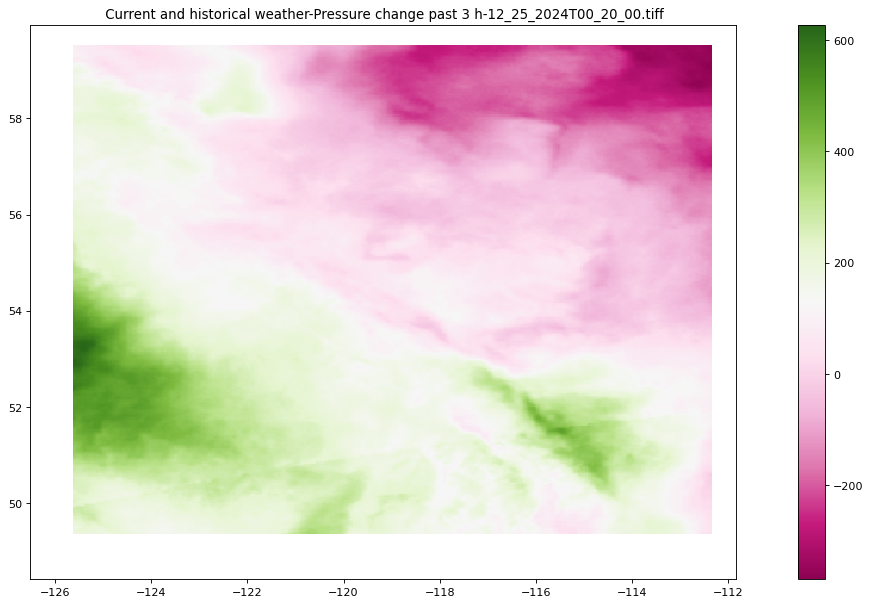

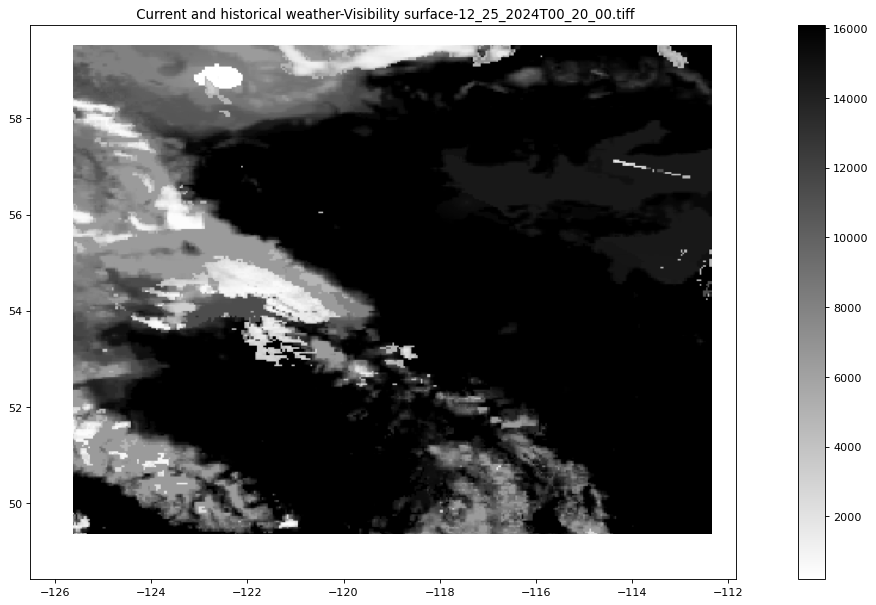

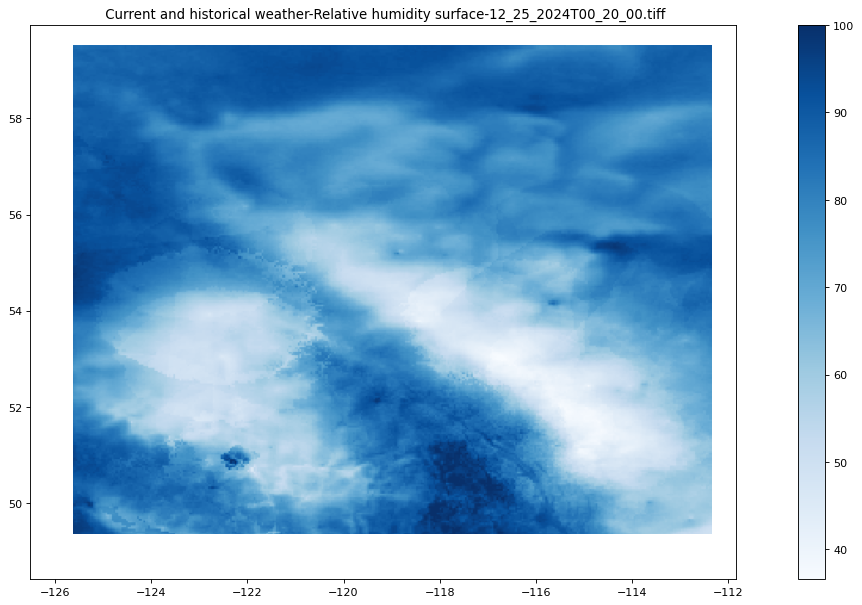

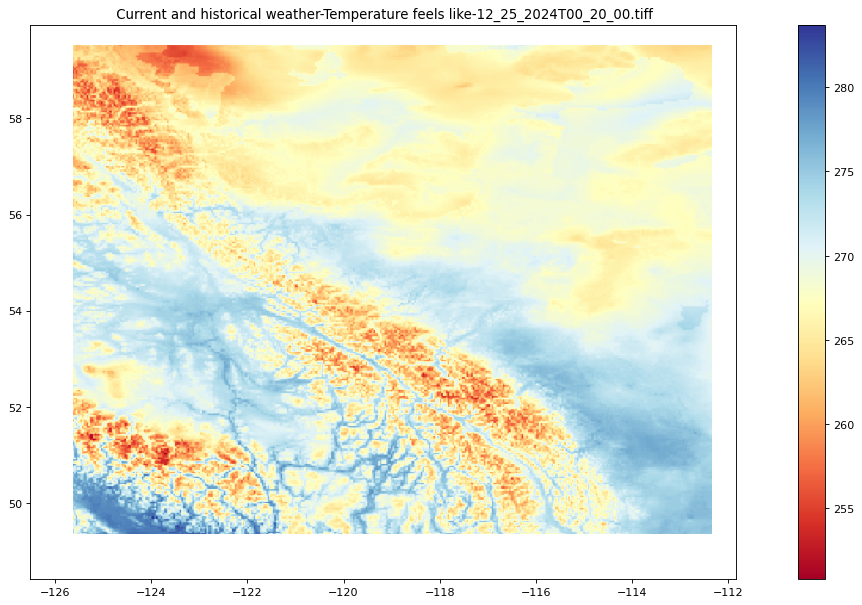

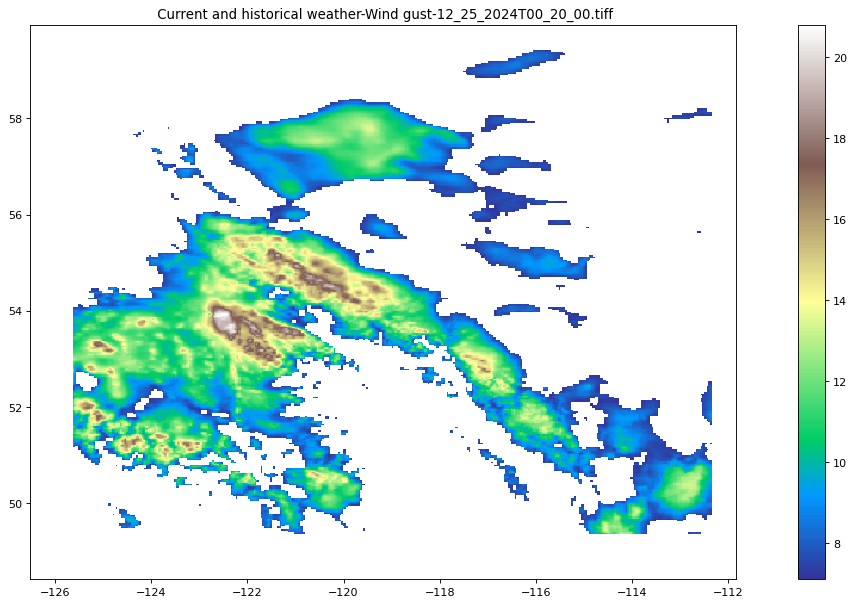

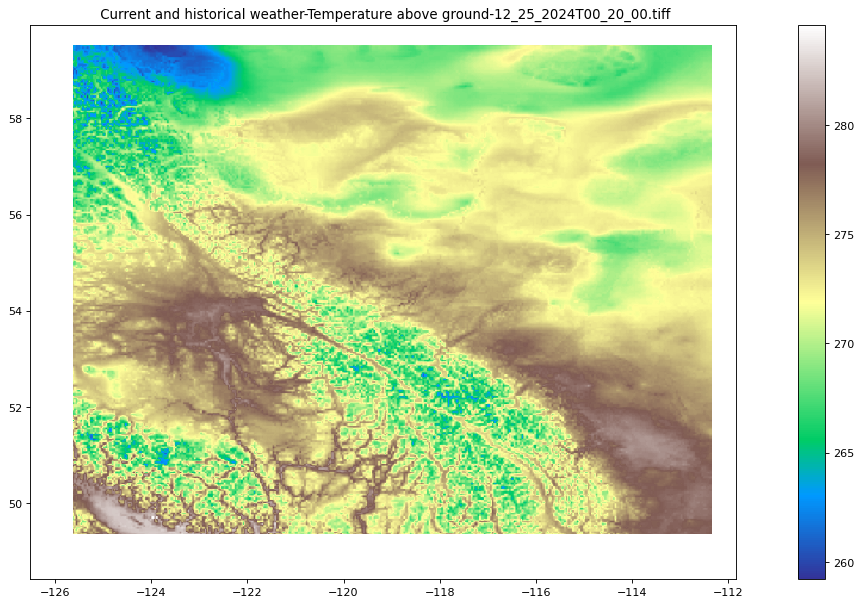

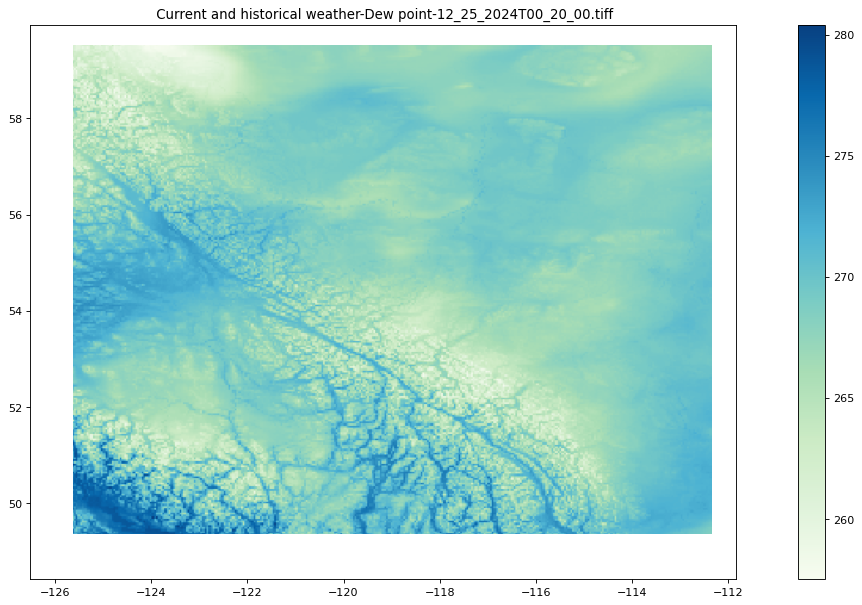

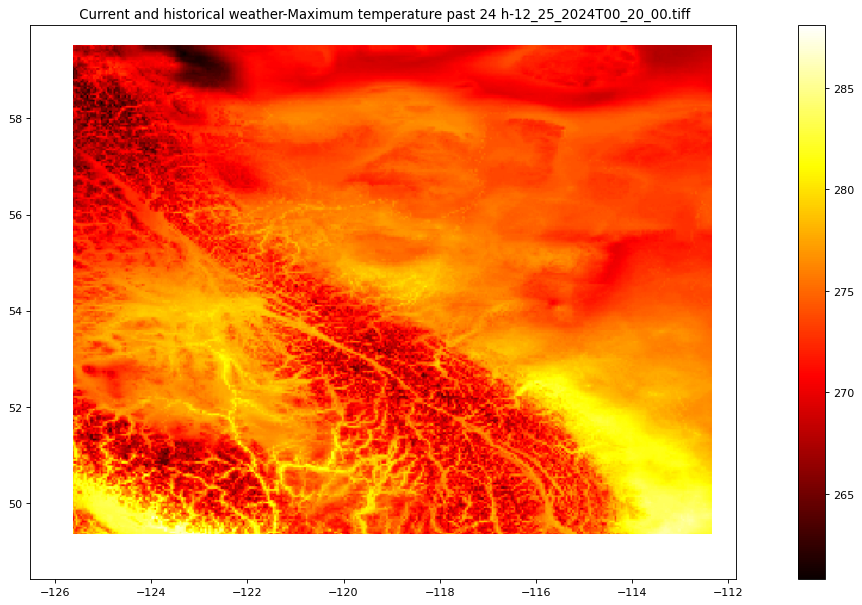

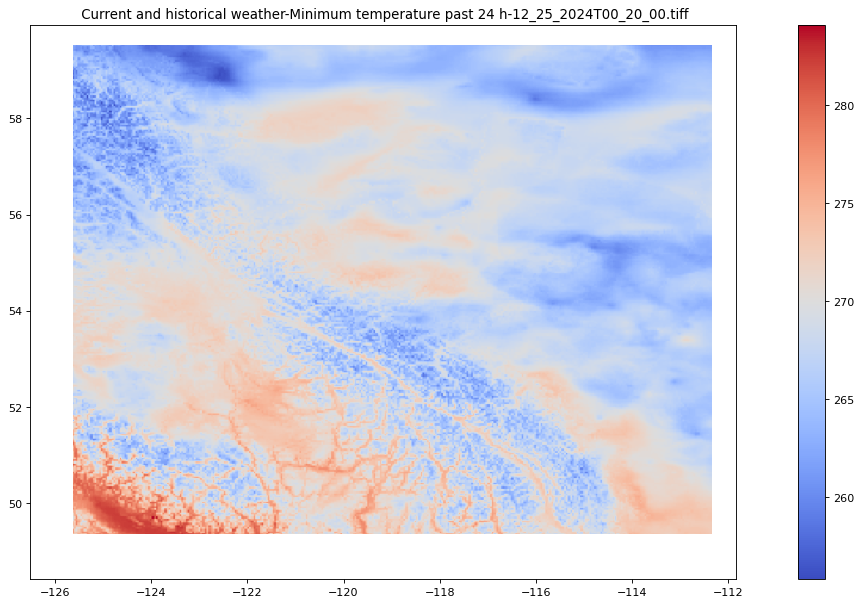

In [58]:
from IPython.display import Image

for output_image in output_image_array:
    # display the raster images
    display(Image(output_image, width=600, height=300))

The raster images above represent key meteorological parameters, each designed to highlight variations in weather conditions. These images convey important data such as relative humidity, minimum and maximum temperature, dew point, pressure changes, visibility, and temperature. By utilizing different visualizations, the images allow for a clear and intuitive understanding of the atmospheric conditions, from variations in moisture levels and temperature extremes to pressure fluctuations and visibility changes across different regions.